In [1]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris() #sklearnについてるサンプルをロード
X = iris.data[:, [2, 3]] #150件のサンプル。2列目と3列目のリストを取ってくる
                         #結果は（２列目と３列目のリスト）のリスト１５０件。
y = iris.target #サンプルの花の種類の分類ラベル。Iris-Setosa,Iris-Versicolor,Iris-verginica
                #に対応してそれぞれ0,1,2が入っている

##モデルを評価するためデータセットを訓練用とテスト用に分割##
from sklearn.cross_validation import train_test_split ##テストデータ分離用の関数
##from sklearn.model_selection import train_test_split(cross_validationは古くなってるので、こちらを推奨)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)   ##30%のデータを取ってくる(test_size=0.3)


##多くの機械学習アルゴリズムには特徴を標準化が必要：(例)最急降下法(p34)##
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()##データセットの標準化(平均値を引いたり,単位を揃えたりして使いやすくする)
sc.fit(X_train)##標準化のため平均と標準偏差を計算する(訓練データもテストデータも同じ値を用いる)
X_train_std = sc.transform(X_train)##標準化を実行
X_test_std = sc.transform(X_test)##同上

##scikit-learnのperceptronを訓練する
##scikit-learnは一対多分類器(One-vs.Rest method)によって3つのクラスに分類可能
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0) ##perceptronのオブジェクトを生成
##(eta0=学習率, n_iter=世代数,random_state=Noneを渡せば世代ごとにランダムデータが生成される。
##整数値を渡すと毎回同じデータが出てくる)
ppn.fit(X_train_std, y_train) ##訓練データの適用

y_pred = ppn.predict(X_test_std)##予想データのベクトルをy_predに
print('Misclassified samples: %d' % (y_test != y_pred).sum())##リスト同士の比較はtrue:1かfalse:0かのリストに変換されるので,その合計値を出している

##45件中4件間違っているため、誤答率は8.9%
##モデルによらずだいたいクラス分類の誤答率はこれくらいの値らしい


from sklearn.metrics import accuracy_score##metricsを用いて色々な測定基準で測定出来る
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))##正答率を答えている



Misclassified samples: 4
Accuracy: 0.91


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


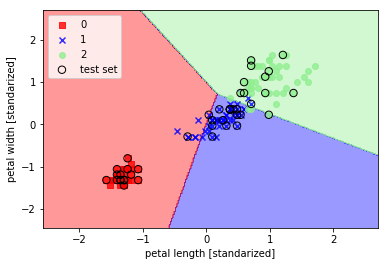

In [2]:
##過学習を検知するためのグラフを用いた方法を５章で学ぶ

#############################################################
##############以下、matplotを利用したグラフ作成する###############
#############################################################

from matplotlib.colors import ListedColormap ##colormapをインポート
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    ##決定領域を塗る関数を定義
    #marker generatorとcolor mapを生成
    markers = ('s', 'x', 'o', '^', 'v') ##使うマーカーを決める
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan') ##使う色を決める
    cmap = ListedColormap(colors[:len(np.unique(y))])##yの種類分だけ色をカラーマップに入れる

    ##決定領域をプロットする
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1 ##入力データの一つ目の特徴の最小値と最大値を設定する
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 0].max() + 1 ##入力データの二つ目の特徴の最小値と最大値を設定する
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    ##引数で渡される分類器（今回はperceptron）の予想値のベクトルを返す(34行目参照)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T) 
    Z = Z.reshape(xx1.shape)##xx1の配列の次元にzの次元を合わせる
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap) ##等高線で塗り分ける関数
    ##引数はx軸、y軸、f(x, y), alpha?, カラーマップ
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())##x軸とy軸の描画範囲の設定

    ##全てのデータ点をプロットする
    for idx, cl in enumerate(np.unique(y)):##インデックス付き(idx)で要素を取り出していく
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8, ##透明度
                    c=cmap(idx),
                    marker=markers[idx],
                    label=cl)##x軸をXの一つ目の特徴、y軸をXの二つ目の特徴にして、idxに対応したカラーマップとマーカーでプロットしていく

    ##テストデータを強調する
    if test_idx: ##関数の引数(50行目).Noneじゃなかったら実行
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black', ##サンプルのままでは表示されない
                    alpha=1.0, linewidths=1, marker='o',
                    s=55, label='test set')

#####描画関数ここまで#######

X_combined_std = np.vstack((X_train_std, X_test_std))##配列を縦に連結
y_combined = np.hstack((y_train, y_test)) ##配列を横に連結
plot_decision_regions(X=X_combined_std, ##先ほど作った描画するための関数を呼び出す
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105,150))
plt.xlabel('petal length [standarized]')
plt.ylabel('petal width [standarized]')
plt.legend(loc='upper left') ##凡例表示
plt.show()

